<a href="https://colab.research.google.com/github/sherryzhong2023-dev/Data-Processing-Project/blob/main/MNE_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MNE Project: Analysis of Visual and Auditory Evoked Fields**
##**Project Goals**:
### 1.   Learn and understand the **main data analysis pipeline** for neuroscientific data in EEG/MEG
*   Artifact rejection (ICA)
*   Signal averaging (Epoching)
*   Functinoal localization (Difference Topomaps)

### 2.   Visualise the principle of **contralateral processing** in the brain.
*   Contralateral processing is when the **brain processes information** from the **opposite side of the body**.
*   For **visual processing**, information from your **left visual field (what you see on your left side)** is processed by the **right hemisphere of your brain**, and information from your right visual field is processed by the left hemisphere.
*   For **auditory processing**, information from your **left side (what hear on your left side)** is processed by the **right hemisphere of your brain**, and information from your right visual field is processed by the left hemisphere. However, the auditory pathway also involves some **ipsilateral processing** of signals. This means the auditory information you hear on right side is also processed by the right hemisphere of your brain.




In [1]:
# install MNE library
!pip install -q mne



In [2]:
%matplotlib inline
import mne
import matplotlib.pyplot as plt

#Data and Experiment Informtaion

The dataset comes from MNE library sample data. It includes both EEG and MEG data. EEG data from a 60-channel electrode cap was acquired simultaneously with the MEG.
* **EEG** measures the **electrical fields** produced by the brain on the scalp.
* **MEG** measures the **magnetic fields** produced by the same electrical activity. MEG has the advantage of not being distorted by the skull, which provides clearer localization.

In this experiment, the subject was presented
* **Checkerboard Patterns** to the left or right visual field
* **Auditory Tones** to the left or right ear

The evoked responses provide evidence of **contralateral processing**.

**Contralateral Processing:** A principle in neuroscience where one side of the brain processes information from the opposite side of the body or sensory field.
* Vision: **Left visual field** information is sent to the **Right Occipital Lobe**.
* Audition: Sound entering the **left ear** is processed primarily by the **Right Temporal Lobe**.

In [3]:
# download MNE library sample dataset
data_path = mne.datasets.sample.data_path()
raw_fname = (data_path / "MEG" / "sample" / "sample_audvis_filt-0-40_raw.fif")

# load raw data
raw = mne.io.read_raw_fif(raw_fname)
print(raw)

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~3.2 MiB, data not loaded>


# Step 1: Visualise Data
**Power Spectral Density (PSD)** shows how much *power (energy)* the signal has at each frequency. In other words, it presents which frequencies would dominate the data. The x-axis represents frequency (Hz) and the y-axis represents power.

*   EEG - **electrical potential** at scalp
*   Gradiometers (MEG) — measure the **spatial gradient change** of the magnetic field.
*   Magnetometers (MEG) — measure the magnetic field strength from brain activity directly. **Very sensitive** to environmental magnetic noise and high-frequency muscle contractions (jaw clenching, head movement) can appear as sharp peaks

**Frequency Values**
*   0–1 Hz - very slow drifts (often artifacts)
*   1–4 Hz - delta (deep sleep, slow waves)
*   4–8 Hz - theta (drowsiness, working memory)
*   8–12 Hz - alpha (relaxed wakefulness, eyes closed) - an **alpha hill** in EEG reflect participants not actively processing stimuli or eye closed
*   13–30 Hz - beta (motor, attention) - a **beta hill** in EEG reflect participants engaged in active attention, cognitive processing, or motor preparation.
*   30–50 Hz - low gamma (sensory/motor, muscle activity)

**Time Signal Traces** shows what the sensors recorded over time. Each line represents one sensor (EEG or MEG channel), with time on the x-axis and amplitude on the y-axis. **Sudden spikes** are likely blinks, muscle activity, or movement artifacts. **Rhythmic waves** (like slow oscillations) are brain activity.

*   duration=5: show 5 seconds of data per screen
*   n_channels=30: 30 channels stacked vertically.

# Step 2: Data Preprocessing for Artifact Removal
**The raw data (EEG/MEG signals)** is always noisy, which contains lots of unwanted signals from sources other than the targeted brain responses. For example, ***eye blinking, muscle movements, and head motions*** can all contaminate the signals.

These artifacts are **electrically/magnetically huge** compared to the tiny brain signals we want to measure (e.g., the brain signal is about 1/100th the size of an eye blink).

Therefore, it is necessary to first **filter out the noise** as much as possible before the actual analysis.

Using matplotlib as 2D backend.


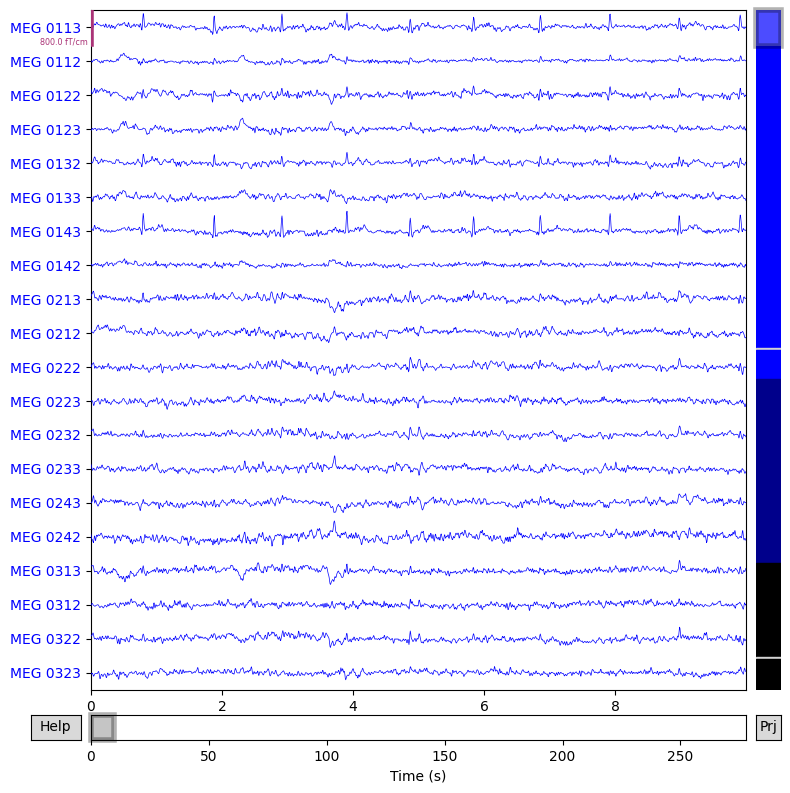

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


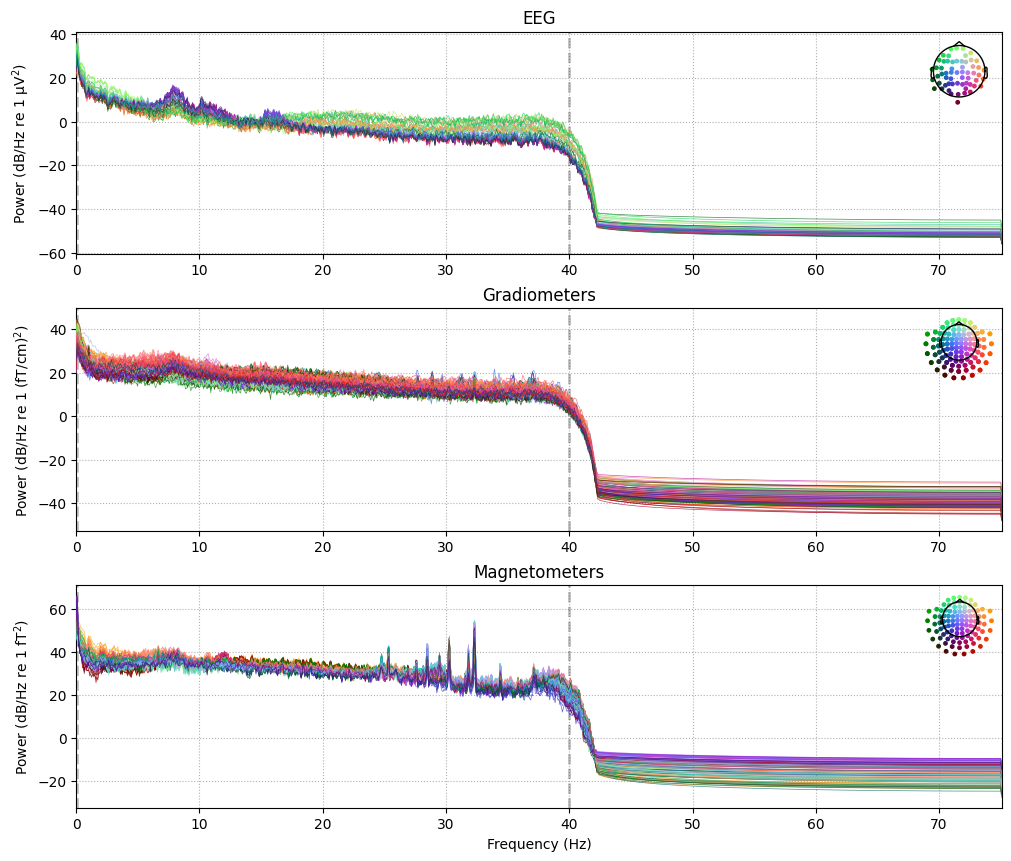

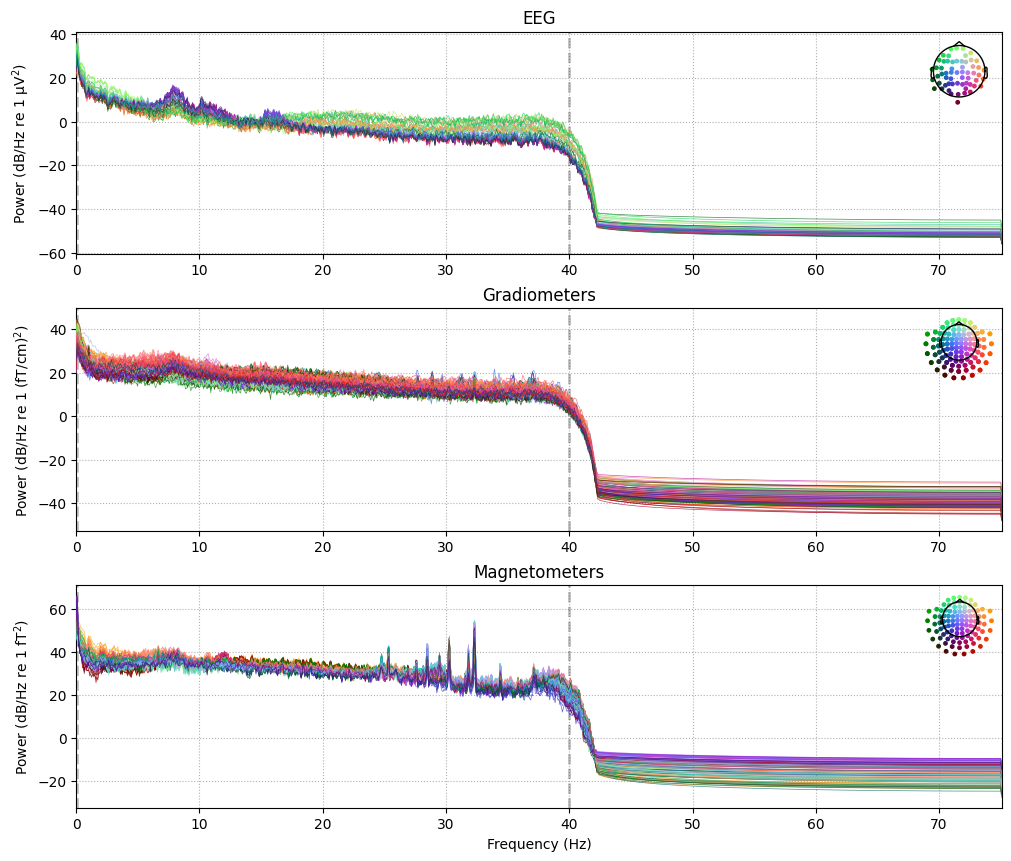

In [4]:
# visualise raw data
raw.plot()
mne.viz.plot_raw_psd(raw)

Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


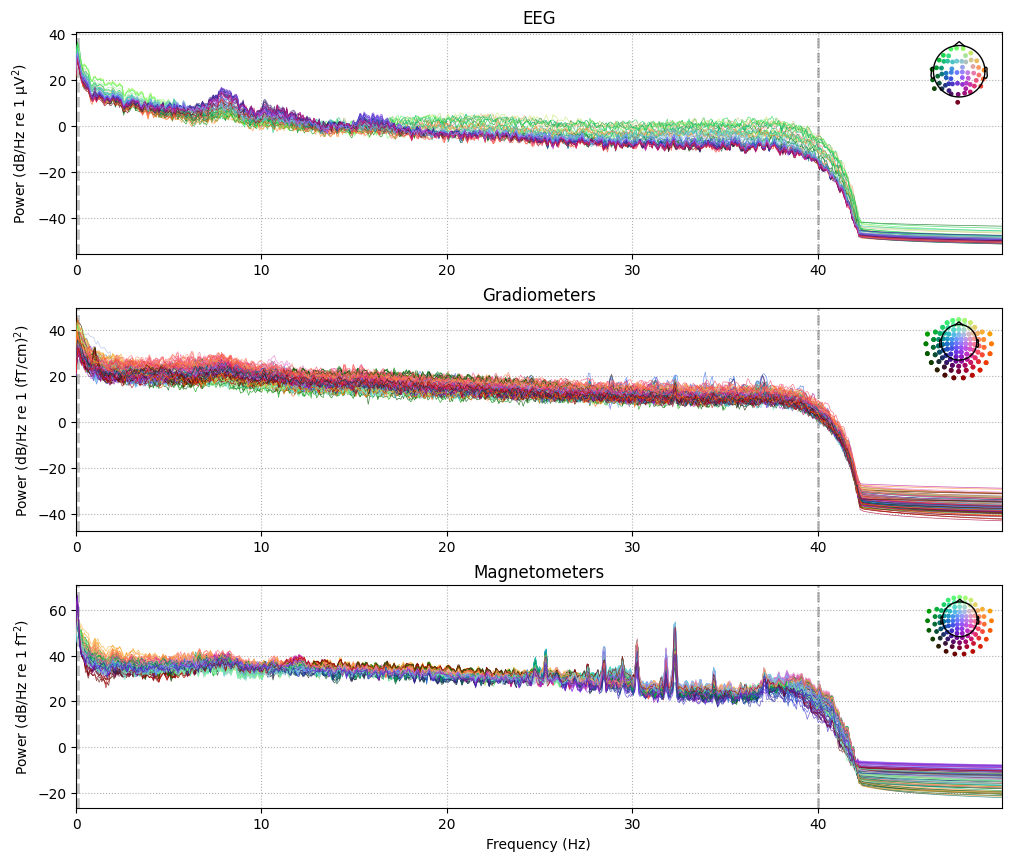

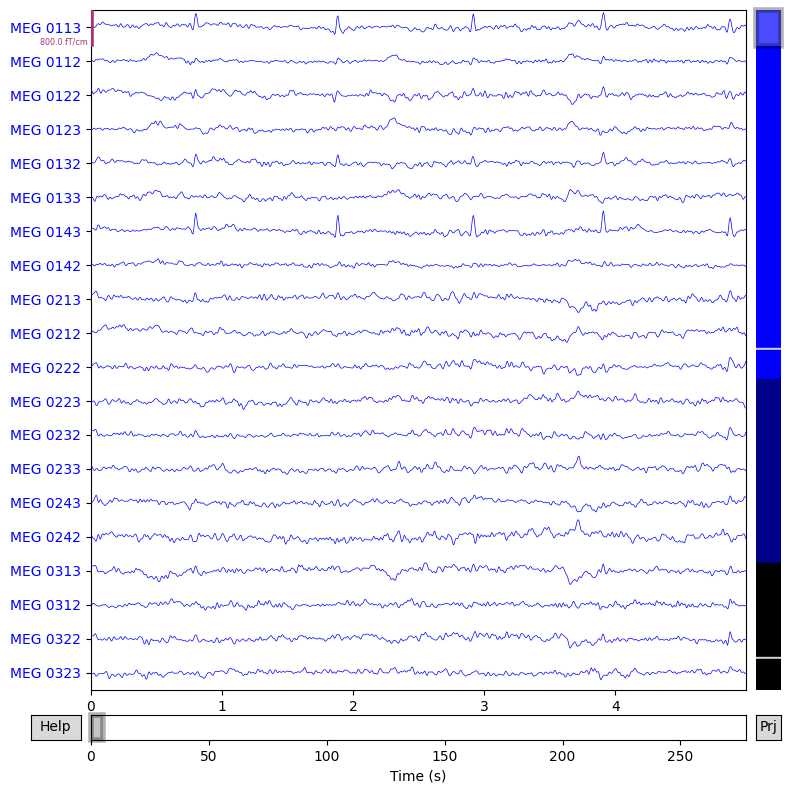

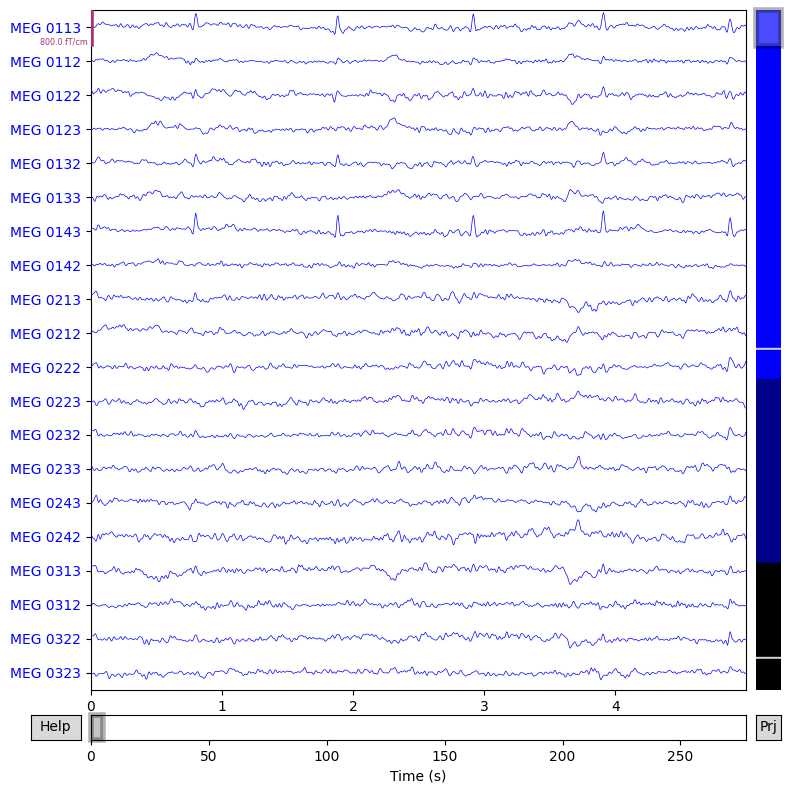

In [5]:
# filtered PSD
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5)

### **The Effect of Filtering on the PSD plots above:**
The Power Spectral Density (PSD) plot shows the energy at each frequency. After filtering, the raw plot is smoother and reflects the actual brain's rhythm more accurately.


##**Independent components analysis (ICA)**
### It is a technique for **estimating independent source signals** from a set of recordings in which the source signals were mixed together in unknown ratios. In EEG/MEG analysis, sensor channels simutaneously pick up *activities from different areas of the brain as well as noises*. As long as these various source signals are statistically independent and non-gaussian, it is usually possible to separate the sources using ICA, and then re-construct the sensor signals after excluding the sources that are unwanted.

### The goal of ICA is to **separate independent sources** like brain signal, eye blink, heartbeat, and muscle activity. Therefore, it can serve as a **mathematical tool to clean data** by *isolating noise sources*, allowing the removal of the noise before doing the localization or averaging.

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 15.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


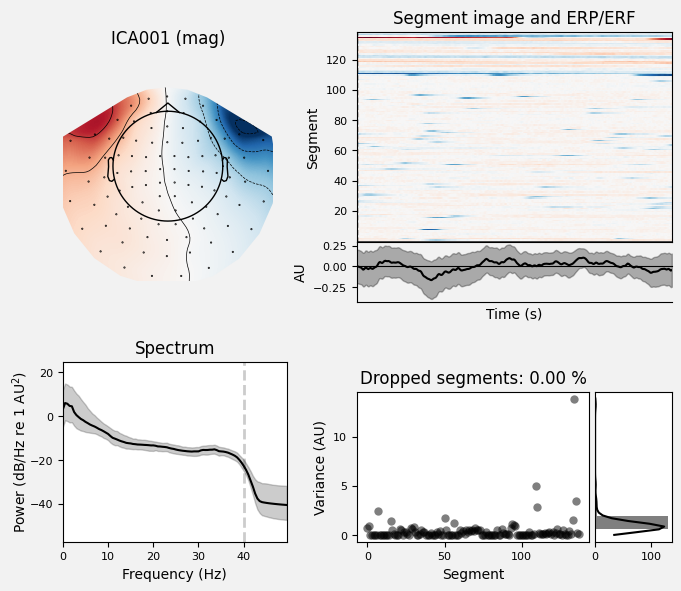

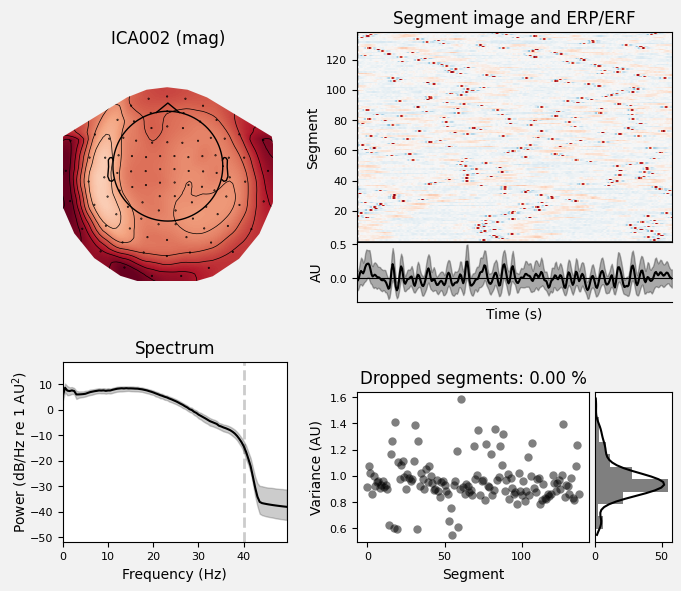

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [6]:
# set up and fit the ICA
# conventionally, 20 components are picked up for major brain and noise sources
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)

# the tutorial preset components 1 and 2 to be artifacts
ica.exclude = [1, 2]

# explanation of the plot properties in the next cell
ica.plot_properties(raw, picks=ica.exclude)

##**The Topomap (Head Plot)**: spatial distribution of the component's activity on the scalp.

###1.   **ICA001 (mag)**: shows a **dipolar** pattern, red (positive field) at the front and blue (negative field) at the back. The signal comes from outside the head, so it would be some external noise rather than the neural activities
###2.   **ICA002 (mag)**: strong, **unipolar** (all red) pattern centered over the **entire front of the head**. This is the classic signature of an **eye-blink artifact (EOG)**, as the signal originates from the **frontal eye muscles**. The electrical field generated by the eye muscles during a blink is so large and close to the frontal sensors that it registers as a **massive, uniform voltage shift** across the entire front of the scalp.


##**The Time Series/ERP Plot**: the component's time course over trials.
### **ICA002 (mag)**: random red dots all over the place, indicating sparse high amplitude blinks.

## **The Spectrum Plot**: EOG components usually have high power at low frequencies (below 4 Hz), consistent with the slow nature of a blink.

### **ICA002 (mag)**: High power density at low frequencies (below 4 Hz) and then rapidly drops. These corresponds to slow, large voltage changes characterised by blink artifacts (EOG).

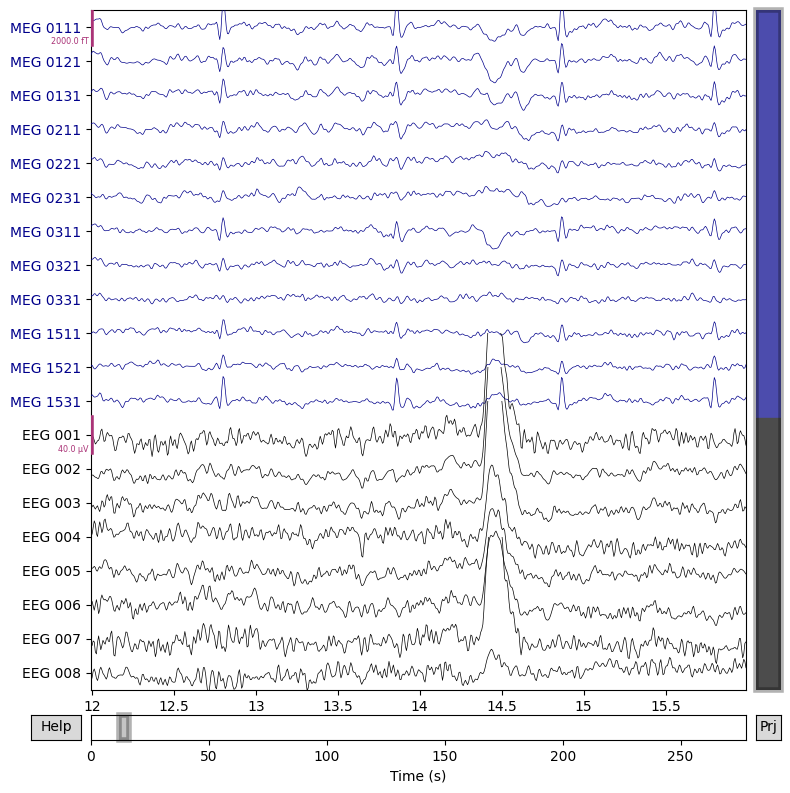

Reading 0 ... 41699  =      0.000 ...   277.709 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MiB, data loaded>

In [7]:
# show some frontal channels to clearly illustrate the artifact removal
# frontal channels are where eye-blink artifacts being most visible
# MEG: Sensors over the frontal, orbital, and anterior temporal regions.
# EEG 001 - 008: The frontal EEG electrodes near the eyes.
chs = [
    "MEG 0111",
    "MEG 0121",
    "MEG 0131",
    "MEG 0211",
    "MEG 0221",
    "MEG 0231",
    "MEG 0311",
    "MEG 0321",
    "MEG 0331",
    "MEG 1511",
    "MEG 1521",
    "MEG 1531",
    "EEG 001",
    "EEG 002",
    "EEG 003",
    "EEG 004",
    "EEG 005",
    "EEG 006",
    "EEG 007",
    "EEG 008",
]

chan_idxs = [raw.ch_names.index(ch) for ch in chs]

# backup copy of raw data for later comparison
orig_raw = raw.copy()

# raw data with eye blinking spikes
orig_raw.plot(order=chan_idxs, start=12, duration=4)

# load data into memory
raw.load_data()

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


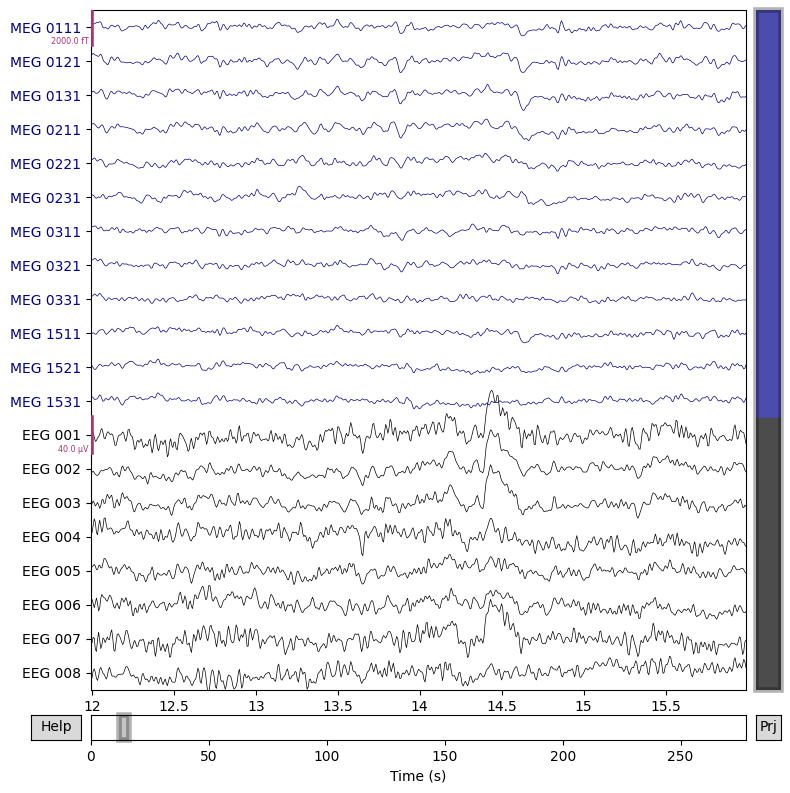

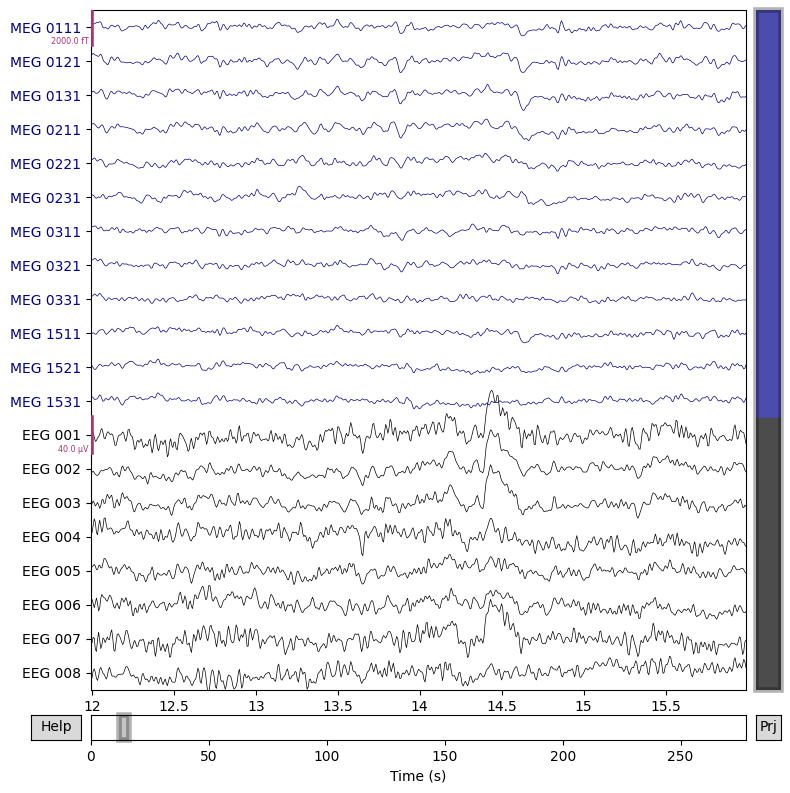

In [8]:
# artifact removal
# maps the sensor data back into the 20 independent components
# sets the signal for the excluded components (ICA 001 and 002) to zero
ica.apply(raw)

# plot cleaned data without spikes
raw.plot(order=chan_idxs, start=12, duration=4)

## **Cleaned plots** show less spikes

# Step 3: Event Detection for Setting up Epoching
Find out the **exact time points** when the visual and auditory stimuli (checkerboards appearing tones occuring) happened.

In [9]:
# inspect information contained in the raw data
type(raw)

mne.io.fiff.raw.Raw

In [10]:
# check information of the data
print(raw.info.keys())

print("Number of channels:", raw.info['nchan'])
print("Sampling rate (Hz):", raw.info['sfreq'])

# EEG and MEG are brain signals, EOG measures eye movements (ocular artifacts)
# STI is stimulus trigger, electrical pulses sent whenever something happens
print("Type of channels:", set(ch.split()[0] for ch in raw.info['ch_names']))

dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'device_info', 'helium_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'utc_offset', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id'])
Number of channels: 376
Sampling rate (Hz): 150.15374755859375
Type of channels: {'STI', 'EEG', 'MEG', 'EOG'}


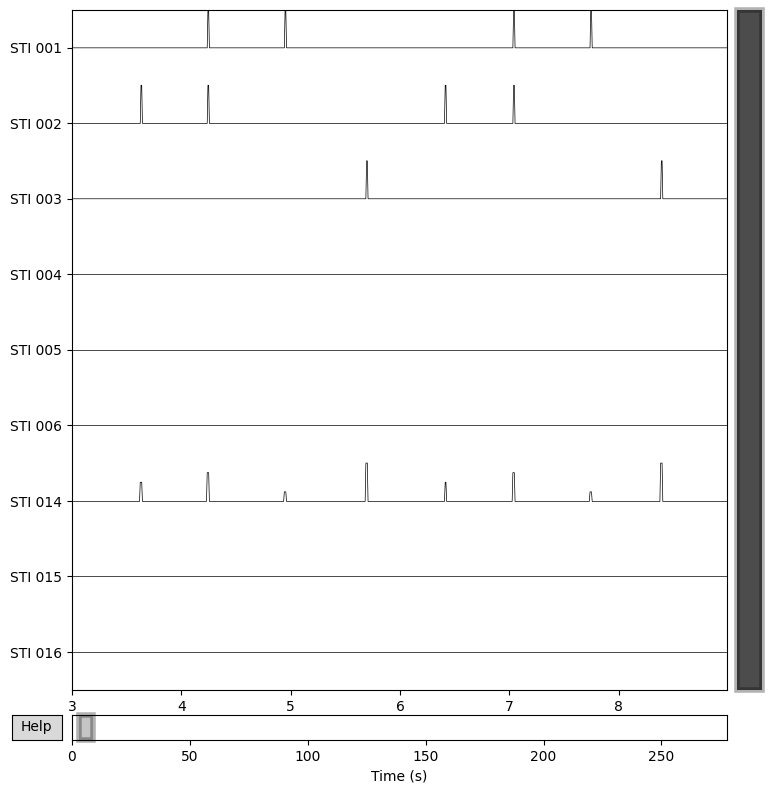

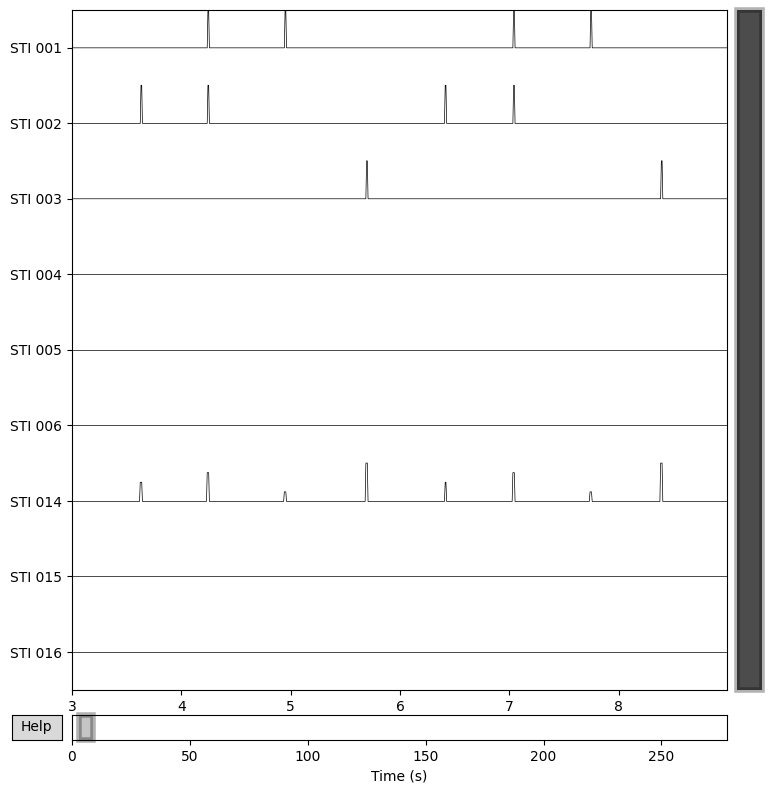

In [11]:
# plot stimulus trigger
raw.copy().pick(picks="stim").plot(start=3, duration=6)

### **STI 014 (the summation channel)** contains pulses of different magnitudes whereas pulses on other channels have consistent magnitudes. *Every time there is a pulse on one of the other STIM channels, there is a corresponding pulse on STI 014*.

### **Event ID Mapping**
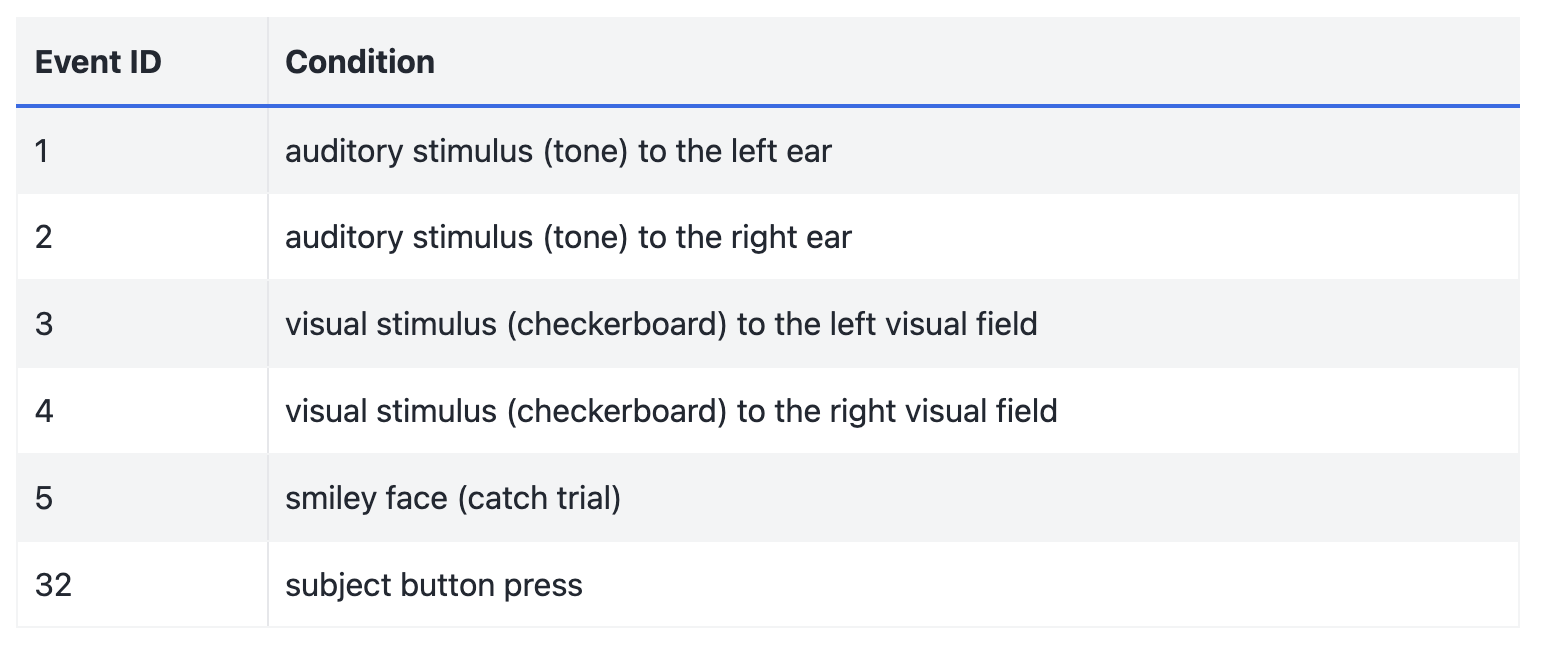

In [12]:
# dictionary that maps event types with event IDs
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}

In [13]:
# find events from stim channel
# shortest trigger set to 1 sample long
events = mne.find_events(raw, stim_channel='STI 014', shortest_event=1)
print("Number of events found:", len(events))
print("\nEach row = [sample_number, previous_code, new_code]")
print("sample_number: where in time samples the event happened")
print("previous_code (usually ignored): the trigger code before the change")
print("event ID — the stimulus type\n")
events[:10]

Finding events on: STI 014
319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Number of events found: 319

Each row = [sample_number, previous_code, new_code]
sample_number: where in time samples the event happened
previous_code (usually ignored): the trigger code before the change
event ID — the stimulus type



array([[6994,    0,    2],
       [7086,    0,    3],
       [7192,    0,    1],
       [7304,    0,    4],
       [7413,    0,    2],
       [7506,    0,    3],
       [7612,    0,    1],
       [7709,    0,    4],
       [7810,    0,    2],
       [7916,    0,    3]])

# Epoching
Epochs are fixed-length segments of continuous data of brain waves. They are time-locked to specific events, like a sound or image. By averaging similar trials together, they can be used to analyze brain responses to certain stimuli.

In [14]:
# preset criteria for rejection from the tutorial
# include or omit thresholds for channel types
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

# compute the actual epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax=0.5,
    reject=reject_criteria,
    preload=True,
)

# focus on auditory and visual events
aud_vis_events = ["auditory/left", "auditory/right", "visual/left", "visual/right"]
epochs.equalize_event_counts(aud_vis_events)
aud_epochs = epochs["auditory"]
vis_epochs = epochs["visual"]

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EEG : ['EEG 008']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
10 bad epochs dropped
Dropped 7 epochs: 121, 195, 258, 271, 273, 274, 275


Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


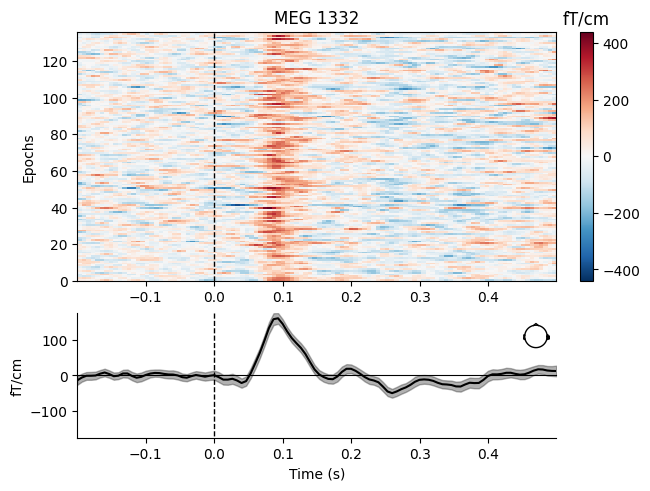

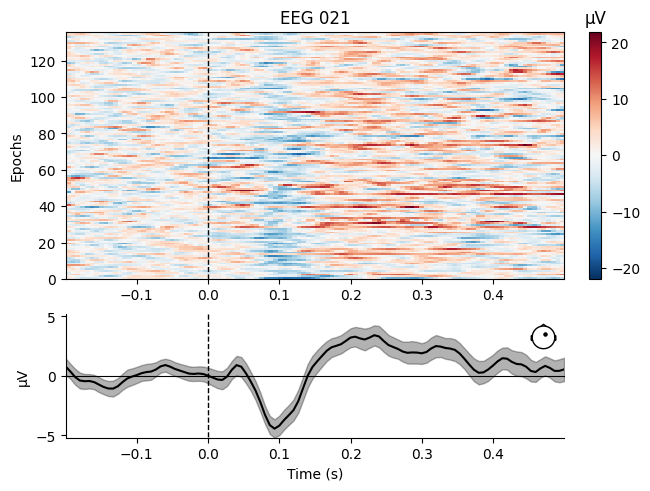

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [15]:
# chosen channels need to match the neuroanatomical locations of the sensory responses
# auditory responses from the temporal lobe (side of the head)
aud_epochs.plot_image(picks=["MEG 1332", "EEG 021"])

Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
136 matching events found
No baseline correction applied
0 projection items activated


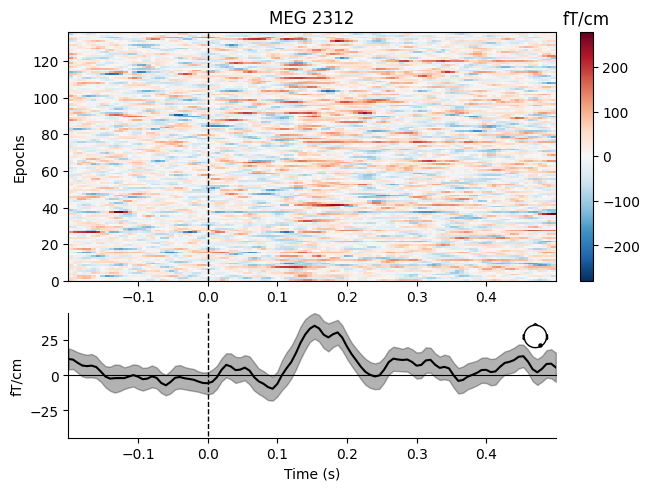

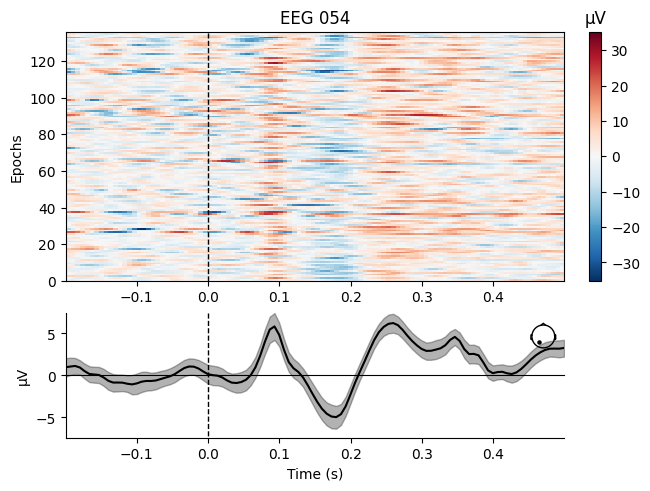

[<Figure size 640x480 with 4 Axes>, <Figure size 640x480 with 4 Axes>]

In [16]:
# visual response from the occipital lobe (back of the head)
vis_epochs.plot_image(picks=["MEG 2312", "EEG 054"])

Clear deflections in voltages

*   Auditory Epochs - N100 reflects the automatic allocation of attention to an incoming sound.
*   Visual Epochs - P100 (Positive 100 ms) and N100/N170 (Negative, later)  reflect the initial processing of visual features and the transfer of information from the primary visual cortex.

# Step 4: Analysis of Visual Evoked Fields

The **magnitudes** (strength of signals) are **NOT informative** because they contain noise and general brain activity.
**The DIFFERENCE is the essential information** for showing the contralateral effect.

* **Averaging (Epoching):** extracts and averages many trials, eliminating random noise.
* **Difference Wave (Left - Right):** cancels out general brain activity, which isolates the effect specific to the hemisphere receiving the strongest input.


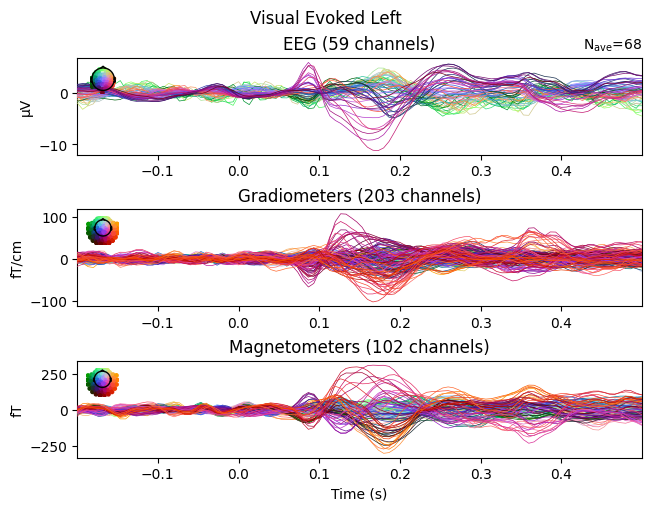

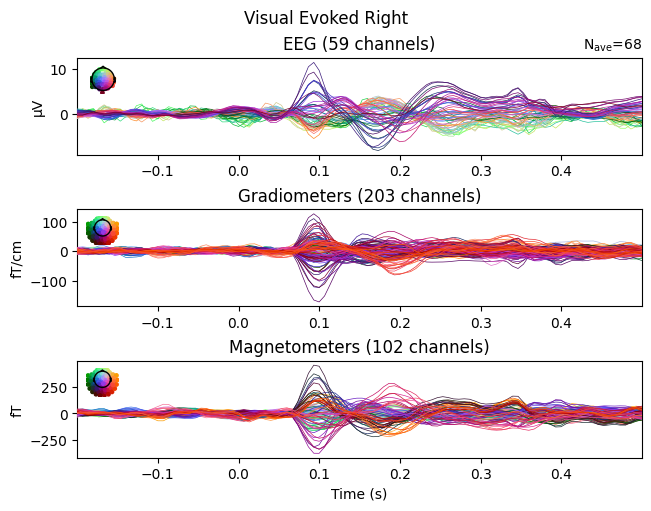

In [17]:
evoked_left_visual = vis_epochs['visual/left'].average()
evoked_right_visual = vis_epochs['visual/right'].average()

# time series plot
fig1_visual = evoked_left_visual.plot(spatial_colors=True, time_unit='s', show=False)
plt.suptitle('Visual Evoked Left')
plt.show()

fig2_visual = evoked_right_visual.plot(spatial_colors=True, time_unit='s', show=False)
plt.suptitle('Visual Evoked Right')
plt.show()


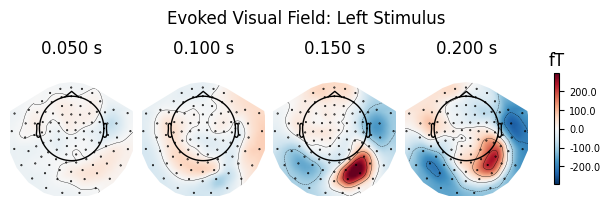

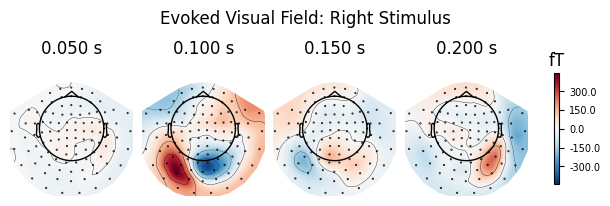

In [18]:
# Choose times of interest (seconds)
visual_times = [0.05, 0.1, 0.15, 0.2]

fig3 = evoked_left_visual.plot_topomap(times=visual_times, time_unit='s', show=False)
plt.suptitle("Evoked Visual Field: Left Stimulus")
plt.show()

fig4 = evoked_right_visual.plot_topomap(times=visual_times, time_unit='s', show=False)
plt.suptitle("Evoked Visual Field: Right Stimulus")
plt.show()

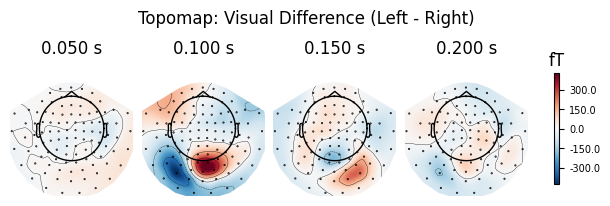

In [19]:
# Plot Difference Wave (Left - Right)
diff_visual = evoked_left_visual.copy()
diff_visual.data = evoked_left_visual.data - evoked_right_visual.data

# Topomap of the difference wave
fig_diff_topo = diff_visual.plot_topomap(times=visual_times, time_unit='s', show=False)
plt.suptitle('Topomap: Visual Difference (Left - Right)')
plt.show()

Strong activity in posterior (occipital) sensors, with red on one side and blue on the other.

If not contralateral, there would be bilateral symmetric red/blue or diffuse non-lateralized patterns.

# Step 5: Analysis of Auditory Evoked Fields
Demonstrate the contralateral response (Left auuditory input -> Right Hemisphere processing) in the Temporal Lobe (sides of the head)

In [20]:
# Calculate the average response
evoked_left_auditory = aud_epochs['auditory/left'].average()
evoked_right_auditory = aud_epochs['auditory/right'].average()

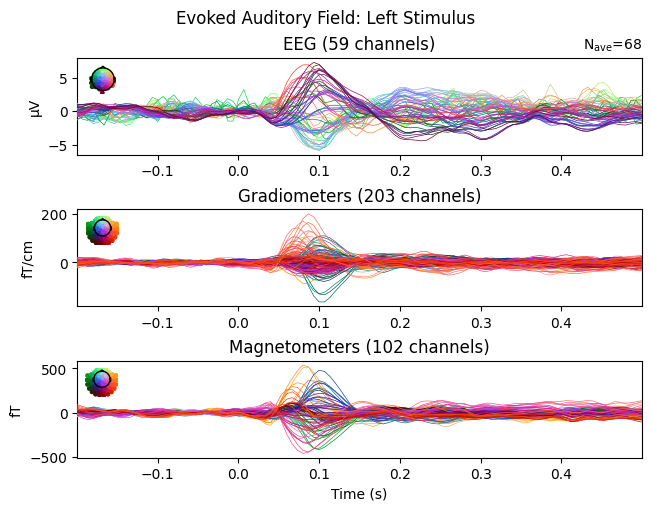

In [21]:
# Time Series Plot (Evoked Auditory Field)
fig1_auditory = evoked_left_auditory.plot(spatial_colors=True, time_unit='s', show=False)
plt.suptitle('Evoked Auditory Field: Left Stimulus')
plt.show()

fig2_auditory = evoked_right_auditory.plot(spatial_colors=True, time_unit='s', show=False)
plt.suptitle('Evoked Auditory Field: Right Stimulus')
plt.show()

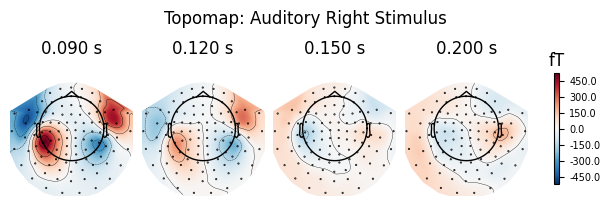

In [22]:
# Topomap Plots
# times of interest for auditory N100 is typically 90-120ms
times_auditory = [0.09, 0.12, 0.15, 0.2]

fig3_auditory = evoked_left_auditory.plot_topomap(times=times_auditory, time_unit='s', show=False)
plt.suptitle('Topomap: Auditory Left Stimulus')
plt.show()

fig4_auditory = evoked_right_auditory.plot_topomap(times=times_auditory, time_unit='s', show=False)
plt.suptitle('Topomap: Auditory Right Stimulus')
plt.show()

In [23]:
# Auditory Difference Wave (Left - Right)
diff_auditory = evoked_left_auditory.copy()
diff_auditory.data = evoked_left_auditory.data - evoked_right_auditory.data

# Topomap of the difference wave to highlight lateralization
fig_diff_topo = diff_auditory.plot_topomap(times=times_auditory, time_unit='s', show=False)
plt.suptitle('Topomap: Auditory Difference (Left - Right)', y=1.0)
plt.show()

Activity over temporal sensors, with mixed red/blue patches on both hemispheres. However, slight dominance alternation do exist.

The auditory difference maps are less clear than the visual ones because the two sensory systems are wired and represented differently in the brain. The contralateral processing in auditory system happens to a smaller degree than vision.

*   visual input is processed in a strongly contralateral manner due to near-complete crossing at the optic chiasm, producing clean left–right separation in occipital cortex and thus high-contrast difference maps
*   auditory input is bilaterally distributed from very early brainstem stages, with each ear projecting to both hemispheres and only a mild contralateral bias. When a sound enters one ear, both auditory cortices become active almost simultaneously, with the contralateral side responding somewhat more strongly.

As a result, contralaterality in audition is relative and graded, so it appears weaker in difference topomaps.